# Intrusion detection with Inception model


by Alwyn Mathew

In [4]:
from IPython.display import Image, display

## Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

import csv
# Functions and classes for loading and using the Inception model.
import inception

# Pretty Tensor to define the new classifier.
import prettytensor as pt

Check prettytessor and tensorflow:

In [6]:
tf.__version__

'1.0.1'

In [7]:
pt.__version__

'0.7.4'

## Load Data

You have to create a `DataSet`-object from the `dataset.py` module. The best way is to use the `load_cached()`-wrapper-function which automatically saves a cache-file with the lists of image-files, so you make sure that the ordering is consistent with the transfer-values created below.

The images must be organized in sub-directories for each of the classes. See the documentation in the `dataset.py` module for more details.

In [8]:
# This is the code you would run to load dataset.

from dataset import load_cached
dataset = load_cached(cache_path='inception_dataset.pkl', in_dir='/home/alwynpcs16/incept_dataset/')
num_classes = dataset.num_classes

Creating dataset from the files in: /home/alwynpcs16/incept_dataset/
- Data loaded from cache-file: inception_dataset.pkl


### Training and Test-Sets

Get the class names.

In [9]:
class_names = dataset.class_names
class_names

['normal', 'alert']

Get the training-set. This returns the file-paths for the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [10]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

Print the first image-path.

In [11]:
image_paths_train[0]

'/home/alwynpcs16/incept_dataset/normal/Alwaye-RLY-ATM-Primary-98509-1488605957585.jpg'

Get the test-set.

In [12]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

Print the first image path.

In [13]:
image_paths_test[0]

'/home/alwynpcs16/incept_dataset/normal/test/Alwaye-RLY-ATM-Primary-96689-1488535255053.jpg'

The ATM dataset has now been loaded and associated labels. The dataset is split into 2 mutually exclusive sub-sets, the training set and the test set.

In [14]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		3719
- Test-set:		1000


### Function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [15]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Function for loading images

This dataset does not load the actual images, instead it has a list of the images in the training-set and another list for the images in the test-set. This function loads some image-files.

In [16]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Plot a few images

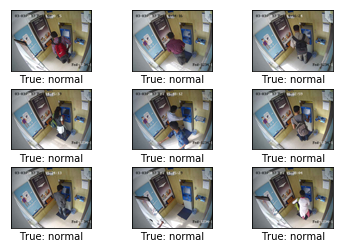

In [17]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## Download the Inception Model

Specify directory where you want to save the data-files. The directory will be created if it does not exist.

In [18]:
inception.data_dir = '/home/alwynpcs16/tutorial/inception/'

In [19]:
inception.data_dir

'/home/alwynpcs16/tutorial/inception/'

Download the data for the Inception model if it doesn't already exist in the directory.

In [20]:
inception.maybe_download()

test download func
Data has apparently already been downloaded and unpacked.


## Load the Inception Model

In [21]:
model = inception.Inception()

## Calculate Transfer-Values

Import a function for caching the transfer-values of the Inception model.

In [22]:
from inception import transfer_values_cache

Set the file-paths for the caches of the training set and test set.

In [23]:
file_path_cache_train = os.path.join(inception.data_dir, 'inception_train_dataset.pkl')
file_path_cache_test = os.path.join(inception.data_dir, 'inception_test_dataset.pkl')

In [24]:
print("Processing Inception transfer-values for training images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training images ...
- Data loaded from cache-file: /home/alwynpcs16/tutorial/inception/inception_train_dataset.pkl


In [25]:
print("Processing Inception transfer-values for test images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test images ...
- Data loaded from cache-file: /home/alwynpcs16/tutorial/inception/inception_test_dataset.pkl


Check the shape of the array with the transfer values. There are 3719 images in the training set and for each image there are 2048 transfer values.

In [26]:
transfer_values_train.shape

(3719, 2048)

There are 1000 images in the test set with 2048 transfer values for each image.

In [27]:
transfer_values_test.shape

(1000, 2048)

### Function for plotting transfer-values

In [28]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


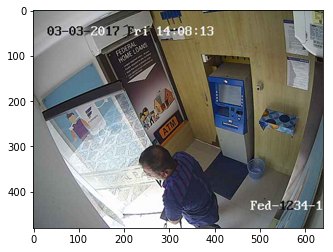

Transfer-values for the image using Inception model:


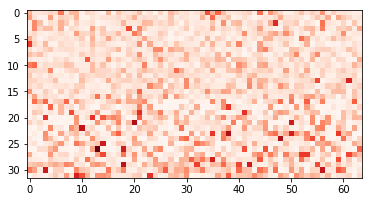

In [29]:
plot_transfer_values(i=100)

Input image:


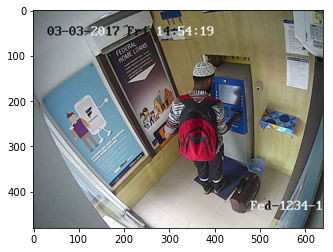

Transfer-values for the image using Inception model:


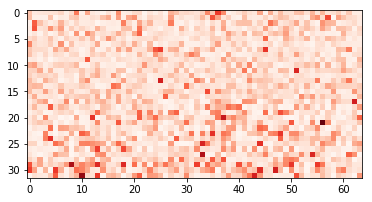

In [30]:
plot_transfer_values(i=300)

## Analysis of Transfer-Values using PCA

Use Principal Component Analysis (PCA) from scikit-learn to reduce the array-lengths of the transfer-values from 2048 to 2 so they can be plotted.

In [31]:
from sklearn.decomposition import PCA

Create a new PCA-object and set the target array-length to 2.

In [32]:
pca = PCA(n_components=2)

In [33]:
# transfer_values = transfer_values_train[0:3000]
transfer_values = transfer_values_train

Get the class numbers for the samples you selected.

In [34]:
# cls = cls_train[0:3000]
cls = cls_train

Check that the array has 3719 samples and 2048 transfer-values for each sample.

In [35]:
transfer_values.shape

(3719, 2048)

Use PCA to reduce the transfer value arrays from 2048 to 2 elements.

In [36]:
transfer_values_reduced = pca.fit_transform(transfer_values)

Check that it is now an array with 3719 samples and 2 values per sample.

In [37]:
transfer_values_reduced.shape

(3719, 2)

Function for plotting the reduced transfer-values.

In [38]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

Plot the transfer values that have been reduced using PCA. PCA cannot properly separate the transfer-values.

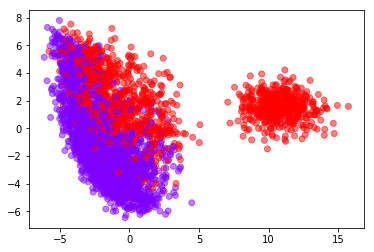

In [39]:
plot_scatter(transfer_values_reduced, cls=cls)

## Analysis of Transfer-Values using t-SNE

In [40]:
from sklearn.manifold import TSNE

Unfortunately, t-SNE is very slow so we first use PCA to reduce the transfer-values from 2048 to 50 elements.

In [41]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

Create a new t-SNE object for the final dimensionality reduction and set the target to 2-dim.

In [42]:
tsne = TSNE(n_components=2)

Perform the final reduction using t-SNE.

In [43]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

Check that it is now an array with 3719 samples and 2 transfer values per sample.

In [44]:
transfer_values_reduced.shape

(3719, 2)

Plot the transfer-values that have been reduced to 2-dim using t-SNE, which shows better separation than the PCA plot above.

This means the transfer-values from the Inception model appear to contain enough information to separate the ATM images into classes, although there is still some overlap so the separation is not perfect.

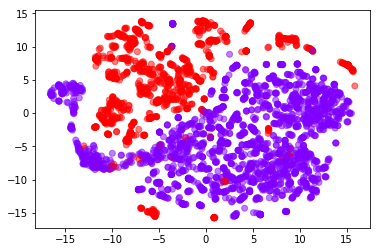

In [45]:
plot_scatter(transfer_values_reduced, cls=cls)

## Classifier in TensorFlow

Create another neural network in TensorFlow. This network will take as input the transfer-values from the Inception model and output the predicted classes for ATM dataset.

### Placeholder Variables

First we need the array-length for transfer-values which is stored as a variable in the object for the Inception model.

In [36]:
transfer_len = model.transfer_len

Now create a placeholder variable for inputting the transfer-values from the Inception model into the new network that we are building. The shape of this variable is `[None, transfer_len]` which means it takes an input array with an arbitrary number of samples as indicated by the keyword `None` and each sample has 2048 elements, equal to `transfer_len`.

In [37]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

Create another placeholder variable for inputting the true class-label of each image. These are so-called One-Hot encoded arrays with 3 elements, one for each possible class in the data-set.

In [38]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Calculate the true class as an integer. This could also be a placeholder variable.

In [39]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

Create the neural network for doing the classification on the ATM dataset. This takes as input the transfer-values from the Inception model which will be fed into the placeholder variable `x`. The network outputs the predicted class in `y_pred`.

In [40]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

Create a variable for keeping track of the number of optimization iterations performed.

In [41]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Method for optimizing the neural network.

In [42]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

The output of the network `y_pred` is an array with 2 elements. The class number is the index of the largest element in the array.

In [43]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Create an array of booleans whether the predicted class equals the true class of each image.

In [44]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the array of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [45]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create TensorFlow Session

In [46]:
session = tf.Session()

### Initialize Variables

The variables for the new network must be initialized.

In [47]:
session.run(tf.global_variables_initializer())

### Function to get a random training-batch

There are 3719 images (and arrays with transfer-values for the images) in the training set. It takes a long time to calculate the gradient of the model using all these images (transfer values).

If your system crashes or becomes very slow because you run out of RAM, then try lowering batch size.

In [48]:
train_batch_size = 64
test_batch_size = 64

Function for selecting a random batch of transfer values from the training-set.

In [49]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [50]:
################################################################
#randon_batch for test_data

def random_batch_test():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_test)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=test_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch_test = transfer_values_test[idx]
    y_batch_test = labels_test[idx]

    return x_batch_test, y_batch_test

### Function to perform optimization

This function performs a number of optimization iterations and accuracy is store into a csv file for plotting.

In each iteration, a new batch of data is selected from the training set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 150 iterations.

In [51]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    if os.path.exists('data_inceptionv3.csv')!=1:
        with open("data_inceptionv3.csv", "w") as f:
                w = csv.writer(f)
                w.writerow(['iteration','accuracy'])
                w.writerow([0,0])
                
    if os.path.exists('data_inceptionv3_test.csv')!=1:
        with open("data_inceptionv3_test.csv", "w") as te:
                t = csv.writer(te)
                t.writerow(['iteration','accuracy'])
                t.writerow([0,0])

    for i in range(num_iterations+1):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()
        
        #########################################################
        # Get a batch of testing examples
        x_batch_test, y_batch_test = random_batch_test()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        ##########################################################
        #Put the test bacth into a dict
        feed_dict_test = {x: x_batch_test,
                           y_true: y_batch_test}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 150 == 0) or (i == num_iterations):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)
            
            #store data to csv for plotting
            ######################################################
            
            with open("data_inceptionv3.csv", "a") as f:
                writer = csv.writer(f)
                writer.writerow([i,batch_acc])
                f.close()
            
            ########################################################

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            
            
            ########################################################
            #Calculate test accuracy
            
            # Print status to screen every 100 iterations (and last).
        if (i_global % 150 == 0) or (i == num_iterations):
            # Calculate the accuracy on the training-batch.
            batch_acc_test = session.run(accuracy,
                                    feed_dict=feed_dict_test)
            
            #store test data acc to csv for plotting
            ######################################################
            
            #iteration=i
            #print_accuracy=batch_acc
            
            with open("data_inceptionv3_test.csv", "a") as te:
                t = csv.writer(te)
                #w.writerow(['iteration','accuracy'])
                t.writerow([i,batch_acc_test])
                te.close()
            
            ########################################################

            # Print status.
            msg = "Global Step: {0:>6}, Testing Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc_test))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Functions for Showing Results

### Function to plot example errors

Function for plotting examples of images from the test set that have been misclassified.

In [52]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

### Function to plot confusion matrix

In [53]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Functions for calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

In [54]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [55]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Functions for calculating the classification accuracy

In [56]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Function for showing the classification accuracy

Function for printing the classification accuracy on the test-set.

In [57]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

## Performance before any optimization

In [58]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 37.3% (373 / 1000)
Confusion Matrix:
[ 27 623] (0) normal
[  4 346] (1) alert
 (0) (1)


## Performance after 5000 optimization iterations

In [59]:
optimize(num_iterations=5000)

Global Step:    150, Training Batch Accuracy:  98.4%
Global Step:    150, Testing Batch Accuracy:  93.8%
Global Step:    300, Training Batch Accuracy: 100.0%
Global Step:    300, Testing Batch Accuracy:  96.9%
Global Step:    450, Training Batch Accuracy: 100.0%
Global Step:    450, Testing Batch Accuracy:  96.9%
Global Step:    600, Training Batch Accuracy: 100.0%
Global Step:    600, Testing Batch Accuracy:  95.3%
Global Step:    750, Training Batch Accuracy: 100.0%
Global Step:    750, Testing Batch Accuracy:  90.6%
Global Step:    900, Training Batch Accuracy: 100.0%
Global Step:    900, Testing Batch Accuracy:  95.3%
Global Step:   1050, Training Batch Accuracy: 100.0%
Global Step:   1050, Testing Batch Accuracy:  98.4%
Global Step:   1200, Training Batch Accuracy: 100.0%
Global Step:   1200, Testing Batch Accuracy:  85.9%
Global Step:   1350, Training Batch Accuracy: 100.0%
Global Step:   1350, Testing Batch Accuracy:  98.4%
Global Step:   1500, Training Batch Accuracy: 100.0%
Gl

Accuracy on Test-Set: 93.7% (937 / 1000)
Example errors:


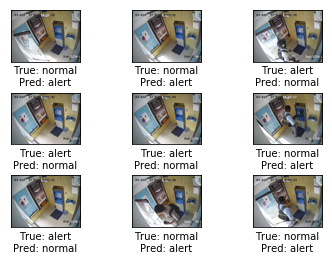

Confusion Matrix:
[604  46] (0) normal
[ 17 333] (1) alert
 (0) (1)


In [60]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources. Note that we have two TensorFlow-sessions so we close both.

In [61]:
model.close()
session.close()